In [1]:
import warnings
import pathlib
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import intake
import healpy

In [2]:
synsat_path = pathlib.Path("/work/bb1376/user/fabian/data/synsat/ngc4008a-zoom8/maxzen")

In [3]:
synsat_files = sorted(list(synsat_path.glob("*.nc")))

In [4]:
synsat_files

[PosixPath('/work/bb1376/user/fabian/data/synsat/ngc4008a-zoom8/maxzen/synsat_ngc4008a-zoom8_maxzen-remapnn2seviri_2021-07-02T0415.nc'),
 PosixPath('/work/bb1376/user/fabian/data/synsat/ngc4008a-zoom8/maxzen/synsat_ngc4008a-zoom8_maxzen_2021-07-01T0015.nc'),
 PosixPath('/work/bb1376/user/fabian/data/synsat/ngc4008a-zoom8/maxzen/synsat_ngc4008a-zoom8_maxzen_2021-07-01T0030.nc'),
 PosixPath('/work/bb1376/user/fabian/data/synsat/ngc4008a-zoom8/maxzen/synsat_ngc4008a-zoom8_maxzen_2021-07-01T0045.nc'),
 PosixPath('/work/bb1376/user/fabian/data/synsat/ngc4008a-zoom8/maxzen/synsat_ngc4008a-zoom8_maxzen_2021-07-01T0100.nc'),
 PosixPath('/work/bb1376/user/fabian/data/synsat/ngc4008a-zoom8/maxzen/synsat_ngc4008a-zoom8_maxzen_2021-07-01T0115.nc'),
 PosixPath('/work/bb1376/user/fabian/data/synsat/ngc4008a-zoom8/maxzen/synsat_ngc4008a-zoom8_maxzen_2021-07-01T0130.nc'),
 PosixPath('/work/bb1376/user/fabian/data/synsat/ngc4008a-zoom8/maxzen/synsat_ngc4008a-zoom8_maxzen_2021-07-01T0145.nc'),
 PosixPat

In [5]:
synsat_files[47]

PosixPath('/work/bb1376/user/fabian/data/synsat/ngc4008a-zoom8/maxzen/synsat_ngc4008a-zoom8_maxzen_2021-07-01T1145.nc')

In [6]:
xr.open_dataset(synsat_files[47])

<xarray.Dataset> Size: 19MB
Dimensions:  (time: 1, cell: 267958)
Coordinates:
    crs      int64 8B ...
  * time     (time) datetime64[ns] 8B 2021-07-01T11:45:00
  * cell     (cell) int64 2MB 0 1 2 3 4 5 ... 267953 267954 267955 267956 267957
    lat      (time, cell) float64 2MB ...
    lon      (time, cell) float64 2MB ...
Data variables:
    bt062    (time, cell) float64 2MB ...
    bt073    (time, cell) float64 2MB ...
    bt087    (time, cell) float64 2MB ...
    bt108    (time, cell) float64 2MB ...
    bt120    (time, cell) float64 2MB ...
    bt134    (time, cell) float64 2MB ...
Attributes:
    author:                Fabian Senf
    contact:               senf@tropos.de
    institution:           Leibniz Institute for Tropospheric Research
    creation_time:         2024-06-14 10:45:30.601007
    synsat_version:        0.1
    synsat_githash:        Undefined
    license:               CC-BY SA 3.0
    _local_software_path:  /home/b/b380352/proj/2022-01_RTTOV-Synsat/synsatip...
    input_filename:        https://data.nextgems-h2020.eu/catalog.yaml

In [7]:
dataset = xr.open_dataset(synsat_files[47])

In [8]:
lon = xr.DataArray(np.arange(-89.95, 90, 0.1)%360, dims=("lon",), name="lon", attrs=dict(units="degrees", standard_name="longitude"))
lat = xr.DataArray(np.arange(89.95, -90, -0.1), dims=("lat",), name="lat", attrs=dict(units="degrees", standard_name="latitude"))

pix = xr.DataArray(
    healpy.ang2pix(dataset.crs.healpix_nside, *np.meshgrid(lon, lat), nest=True, lonlat=True),
    coords=(lat, lon),
)

In [9]:
def get_nest(ds):
    return ds.crs.healpix_order == "nest"
# healpy.mollview(dataset.bt108, flip="geo", nest=get_nest(dataset))

In [10]:
mask = xr.open_dataset("/work/bb1376/user/fabian/data/synsat/ngc4008a-zoom8/aux/ngc4008a-zoom8_maxzen80_mask_for_embedding.nc")

In [11]:
mask

<xarray.Dataset> Size: 16MB
Dimensions:   (cell: 786432)
Coordinates:
    time      datetime64[ns] 8B ...
    crs       int64 8B ...
    lat       (cell) float64 6MB ...
    lon       (cell) float64 6MB ...
Dimensions without coordinates: cell
Data variables:
    zen_mask  (cell) float32 3MB ...

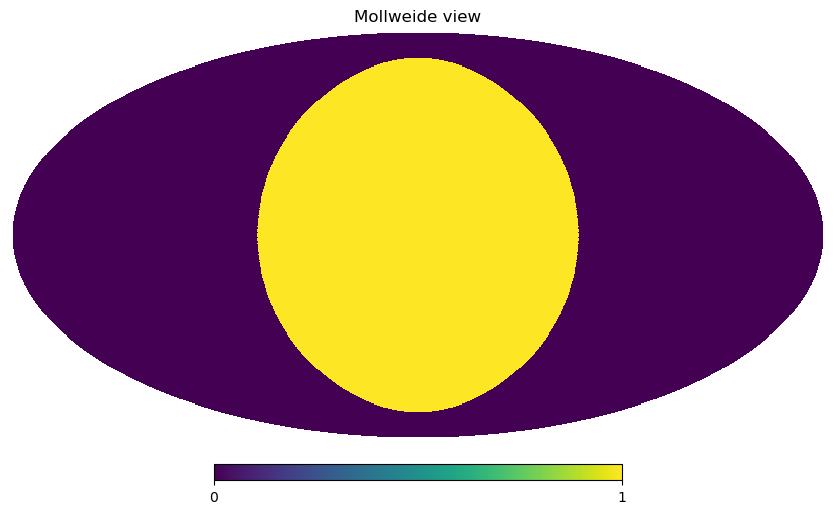

In [12]:
healpy.mollview(mask.zen_mask, flip="geo", nest=get_nest(mask))

In [13]:
global_bt108 = mask.zen_mask.copy()

In [14]:
global_bt108[mask.zen_mask.data==1] = dataset.bt108.data[0]

In [15]:
global_bt108[global_bt108==0] = np.nan

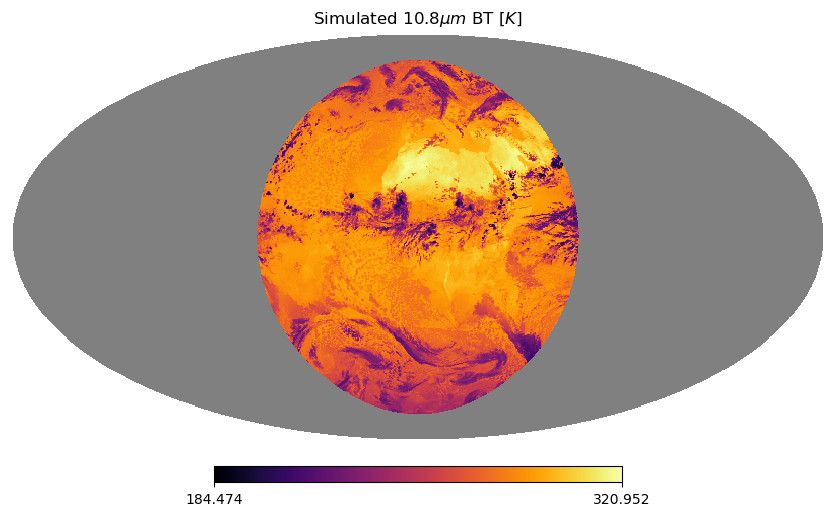

In [16]:
healpy.mollview(global_bt108, flip="geo", nest=get_nest(mask), title="Simulated 10.8$\mu m$ BT [$K$]", cmap="inferno")

In [17]:
cat = intake.open_catalog(
    '/work/bm1235/k203123/nextgems_prefinal/experiments/ngc4008a/outdata/ngc4008a.yaml'
)
ds_icon_inst = cat.ngc4008a(chunks="auto", zoom=8, time='PT15M').to_dask()
ds_icon_inst_1 = ds_icon_inst.sel(time=slice('2021-07-01-00:00:00', '2021-07-08-00:00:00'))
ds_icon_inst_2 = ds_icon_inst.sel(time=slice('2033-07-01-00:00:00', '2033-07-08-00:00:00'))

/home/b/b382728/miniconda3/envs/tobac_flow/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [18]:
icon_slice = ds_icon_inst_1.sel(time=datetime(2021,7,1,12))

In [19]:
icon_slice

<xarray.Dataset> Size: 4GB
Dimensions:     (level_full: 90, cell: 786432, crs: 1, level_half: 91)
Coordinates:
  * crs         (crs) float32 4B nan
  * level_full  (level_full) int32 360B 1 2 3 4 5 6 7 8 ... 84 85 86 87 88 89 90
  * level_half  (level_half) int32 364B 1 2 3 4 5 6 7 8 ... 85 86 87 88 89 90 91
    time        datetime64[ns] 8B 2021-07-01T12:00:00
    zg          (level_full, cell) float32 283MB dask.array<chunksize=(60, 524288), meta=np.ndarray>
    zghalf      (level_half, cell) float32 286MB dask.array<chunksize=(62, 524288), meta=np.ndarray>
Dimensions without coordinates: cell
Data variables: (12/15)
    cli         (level_full, cell) float32 283MB dask.array<chunksize=(30, 262144), meta=np.ndarray>
    clw         (level_full, cell) float32 283MB dask.array<chunksize=(30, 262144), meta=np.ndarray>
    dzghalf     (level_full, cell) float32 283MB dask.array<chunksize=(60, 524288), meta=np.ndarray>
    hus         (level_full, cell) float32 283MB dask.array<chunksize=(30, 262144), meta=np.ndarray>
    pfull       (level_full, cell) float32 283MB dask.array<chunksize=(30, 262144), meta=np.ndarray>
    pr          (cell) float32 3MB dask.array<chunksize=(524288,), meta=np.ndarray>
    ...          ...
    rlut        (cell) float32 3MB dask.array<chunksize=(524288,), meta=np.ndarray>
    ta          (level_full, cell) float32 283MB dask.array<chunksize=(30, 262144), meta=np.ndarray>
    ts          (cell) float32 3MB dask.array<chunksize=(524288,), meta=np.ndarray>
    ua          (level_full, cell) float32 283MB dask.array<chunksize=(30, 262144), meta=np.ndarray>
    va          (level_full, cell) float32 283MB dask.array<chunksize=(30, 262144), meta=np.ndarray>
    wa_phy      (level_half, cell) float32 286MB dask.array<chunksize=(31, 262144), meta=np.ndarray>

In [20]:
icon_slice.cli.mean("level_full")

<xarray.DataArray 'cli' (cell: 786432)> Size: 3MB
dask.array<mean_agg-aggregate, shape=(786432,), dtype=float32, chunksize=(262144,), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 8B 2021-07-01T12:00:00
Dimensions without coordinates: cell

/home/b/b382728/miniconda3/envs/tobac_flow/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 588 times more chunks
  return self.array[key]


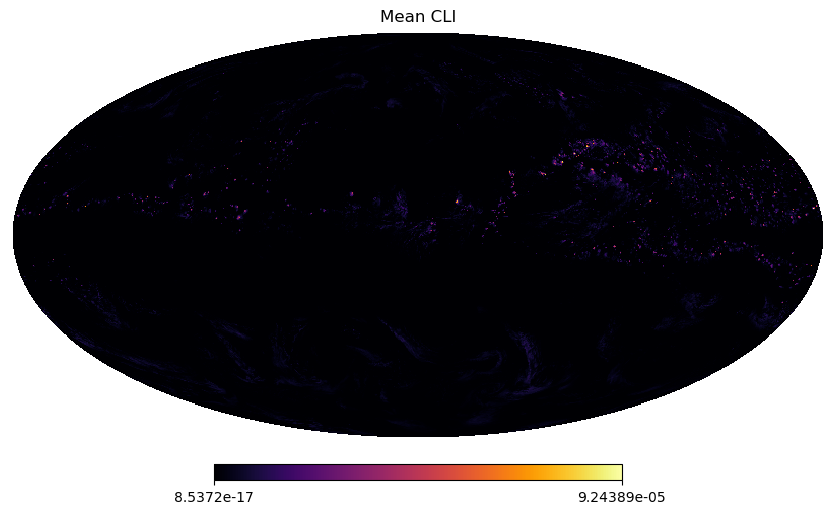

In [21]:
healpy.mollview(icon_slice.cli.mean("level_full"), flip="geo", nest=get_nest(mask), title="Mean CLI", cmap="inferno")

In [22]:
rho = icon_slice.pfull / (287 * icon_slice.ta) #Air density

In [23]:
cell_airmass = rho * icon_slice.dzghalf #Cell airmass path

In [24]:
total_condensate = ((icon_slice.cli + icon_slice.clw + icon_slice.qr + icon_slice.qg + icon_slice.qs) * cell_airmass).sum("level_full")

In [25]:
total_condensate

<xarray.DataArray (cell: 786432)> Size: 3MB
dask.array<sum-aggregate, shape=(786432,), dtype=float32, chunksize=(262144,), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 8B 2021-07-01T12:00:00
Dimensions without coordinates: cell

/home/b/b382728/miniconda3/envs/tobac_flow/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 588 times more chunks
  return self.array[key]


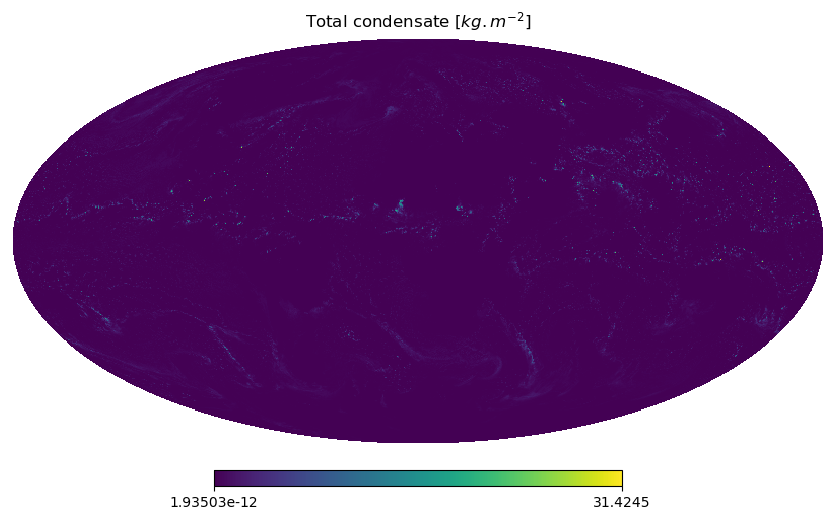

In [26]:
healpy.mollview(total_condensate, flip="geo", nest=get_nest(mask), title="Total condensate [$kg.m^{-2}$]", cmap="viridis")

In [27]:
mask.zen_mask

<xarray.DataArray 'zen_mask' (cell: 786432)> Size: 3MB
array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)
Coordinates:
    time     datetime64[ns] 8B ...
    crs      int64 8B ...
    lat      (cell) float64 6MB ...
    lon      (cell) float64 6MB ...
Dimensions without coordinates: cell
Attributes:
    cell_methods:   time: point cell: mean
    component:      atmo
    grid_mapping:   crs
    long_name:      regional mask for zenith-based masking
    standard_name:  zenith_mask
    units:          -
    vgrid:          surface
    description:    The original healpix grid with zoom = 8 is masked with a ...
    name:           zen_mask

In [28]:
mask.zen_mask.drop(["lat", "lon"]).isel(cell=pix)

/tmp/ipykernel_1854419/2935492453.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  mask.zen_mask.drop(["lat", "lon"]).isel(cell=pix)


<xarray.DataArray 'zen_mask' (lat: 1800, lon: 1800)> Size: 13MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    time     datetime64[ns] 8B ...
    crs      int64 8B ...
  * lat      (lat) float64 14kB 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon      (lon) float64 14kB 270.1 270.1 270.2 270.3 ... 89.75 89.85 89.95
Attributes:
    cell_methods:   time: point cell: mean
    component:      atmo
    grid_mapping:   crs
    long_name:      regional mask for zenith-based masking
    standard_name:  zenith_mask
    units:          -
    vgrid:          surface
    description:    The original healpix grid with zoom = 8 is masked with a ...
    name:           zen_mask

/tmp/ipykernel_1854419/1300625454.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  plt.imshow(mask.zen_mask.drop(["lat", "lon"]).isel(cell=pix))


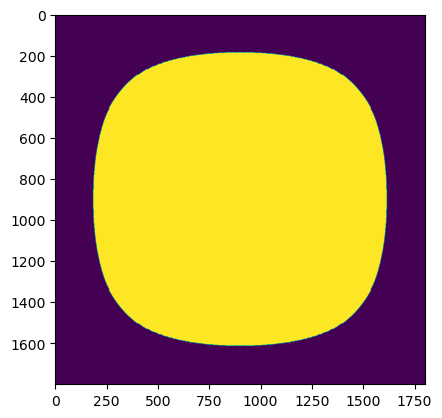

In [29]:
plt.imshow(mask.zen_mask.drop(["lat", "lon"]).isel(cell=pix))